In [1]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.9 MB/s eta 0:00:00


# Importing libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
#from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [3]:
# Reading our dataset
df = pd.read_csv('data/preprocessed_CAC40.csv', parse_dates=['Date'])
df

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415
...,...,...,...,...,...,...,...,...
97643,97643,Worldline SA,2014-07-04,16.22,16.28,16.29,16.22,NaN
97644,97644,Worldline SA,2014-07-03,16.12,16.28,16.28,16.12,NaN
97645,97645,Worldline SA,2014-07-02,16.22,16.17,16.32,16.17,NaN
97646,97646,Worldline SA,2014-07-01,16.42,16.25,16.55,16.25,NaN


# Explorartory Data Analysis

## Preprocessing

In [9]:
# Dropping unnecessary column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['Name'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [11]:
df['Name'].unique().tolist()

['Accor',
 'Air Liquide',
 'Airbus ',
 'ArcelorMittal',
 'Atos',
 'AXA',
 'BNP Paribas',
 'Bouygues',
 'Cap Gemini',
 'Crédit Agricole',
 'Danone',
 'Dassault Systèmes',
 'Engie (ex GDF Suez',
 'EssilorLuxottica',
 'Hermès (Hermes International',
 'Kering',
 'LEGRAND',
 'LOréal',
 'LVMH Moet Hennessy Louis Vuitton',
 'Michelin (Compagnie Générale d Etablissements Michelin SCPA',
 'Orange',
 'Pernod Ricard',
 'Peugeot',
 'Publicis',
 'Renault',
 'SAFRAN',
 'Saint-Gobain',
 'Sanofi',
 'Schneider Electric',
 'Société Générale (Societe Generale',
 'Sodexo',
 'STMicroelectronics',
 'TOTAL',
 'Unibail-Rodamco',
 'Veolia Environnement',
 'VINCI',
 'Vivendi',
 'Worldline SA']

In [12]:
# Selecting any random company out of our 'Name' column
company_name = random.choice(df['Name'].unique().tolist())
# Setting the start and end date
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2020,1,1)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)

In [13]:
specific_df

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
26061,Danone,2019-12-30,74.66,74.16,74.66,74.12,284
26062,Danone,2019-12-27,74.16,74.90,74.90,74.16,23
26063,Danone,2019-12-23,74.66,74.42,74.66,74.42,943
26064,Danone,2019-12-20,73.90,74.60,74.60,73.90,"1,355"
26065,Danone,2019-12-19,73.96,73.56,73.96,73.56,296
...,...,...,...,...,...,...,...
27570,Danone,2014-01-08,48.18,47.69,48.42,47.52,"1,785"
27571,Danone,2014-01-07,47.64,48.22,48.22,47.64,"1,761"
27572,Danone,2014-01-06,48.00,47.48,48.00,47.48,"2,117"
27573,Danone,2014-01-03,47.66,47.86,47.86,47.66,111


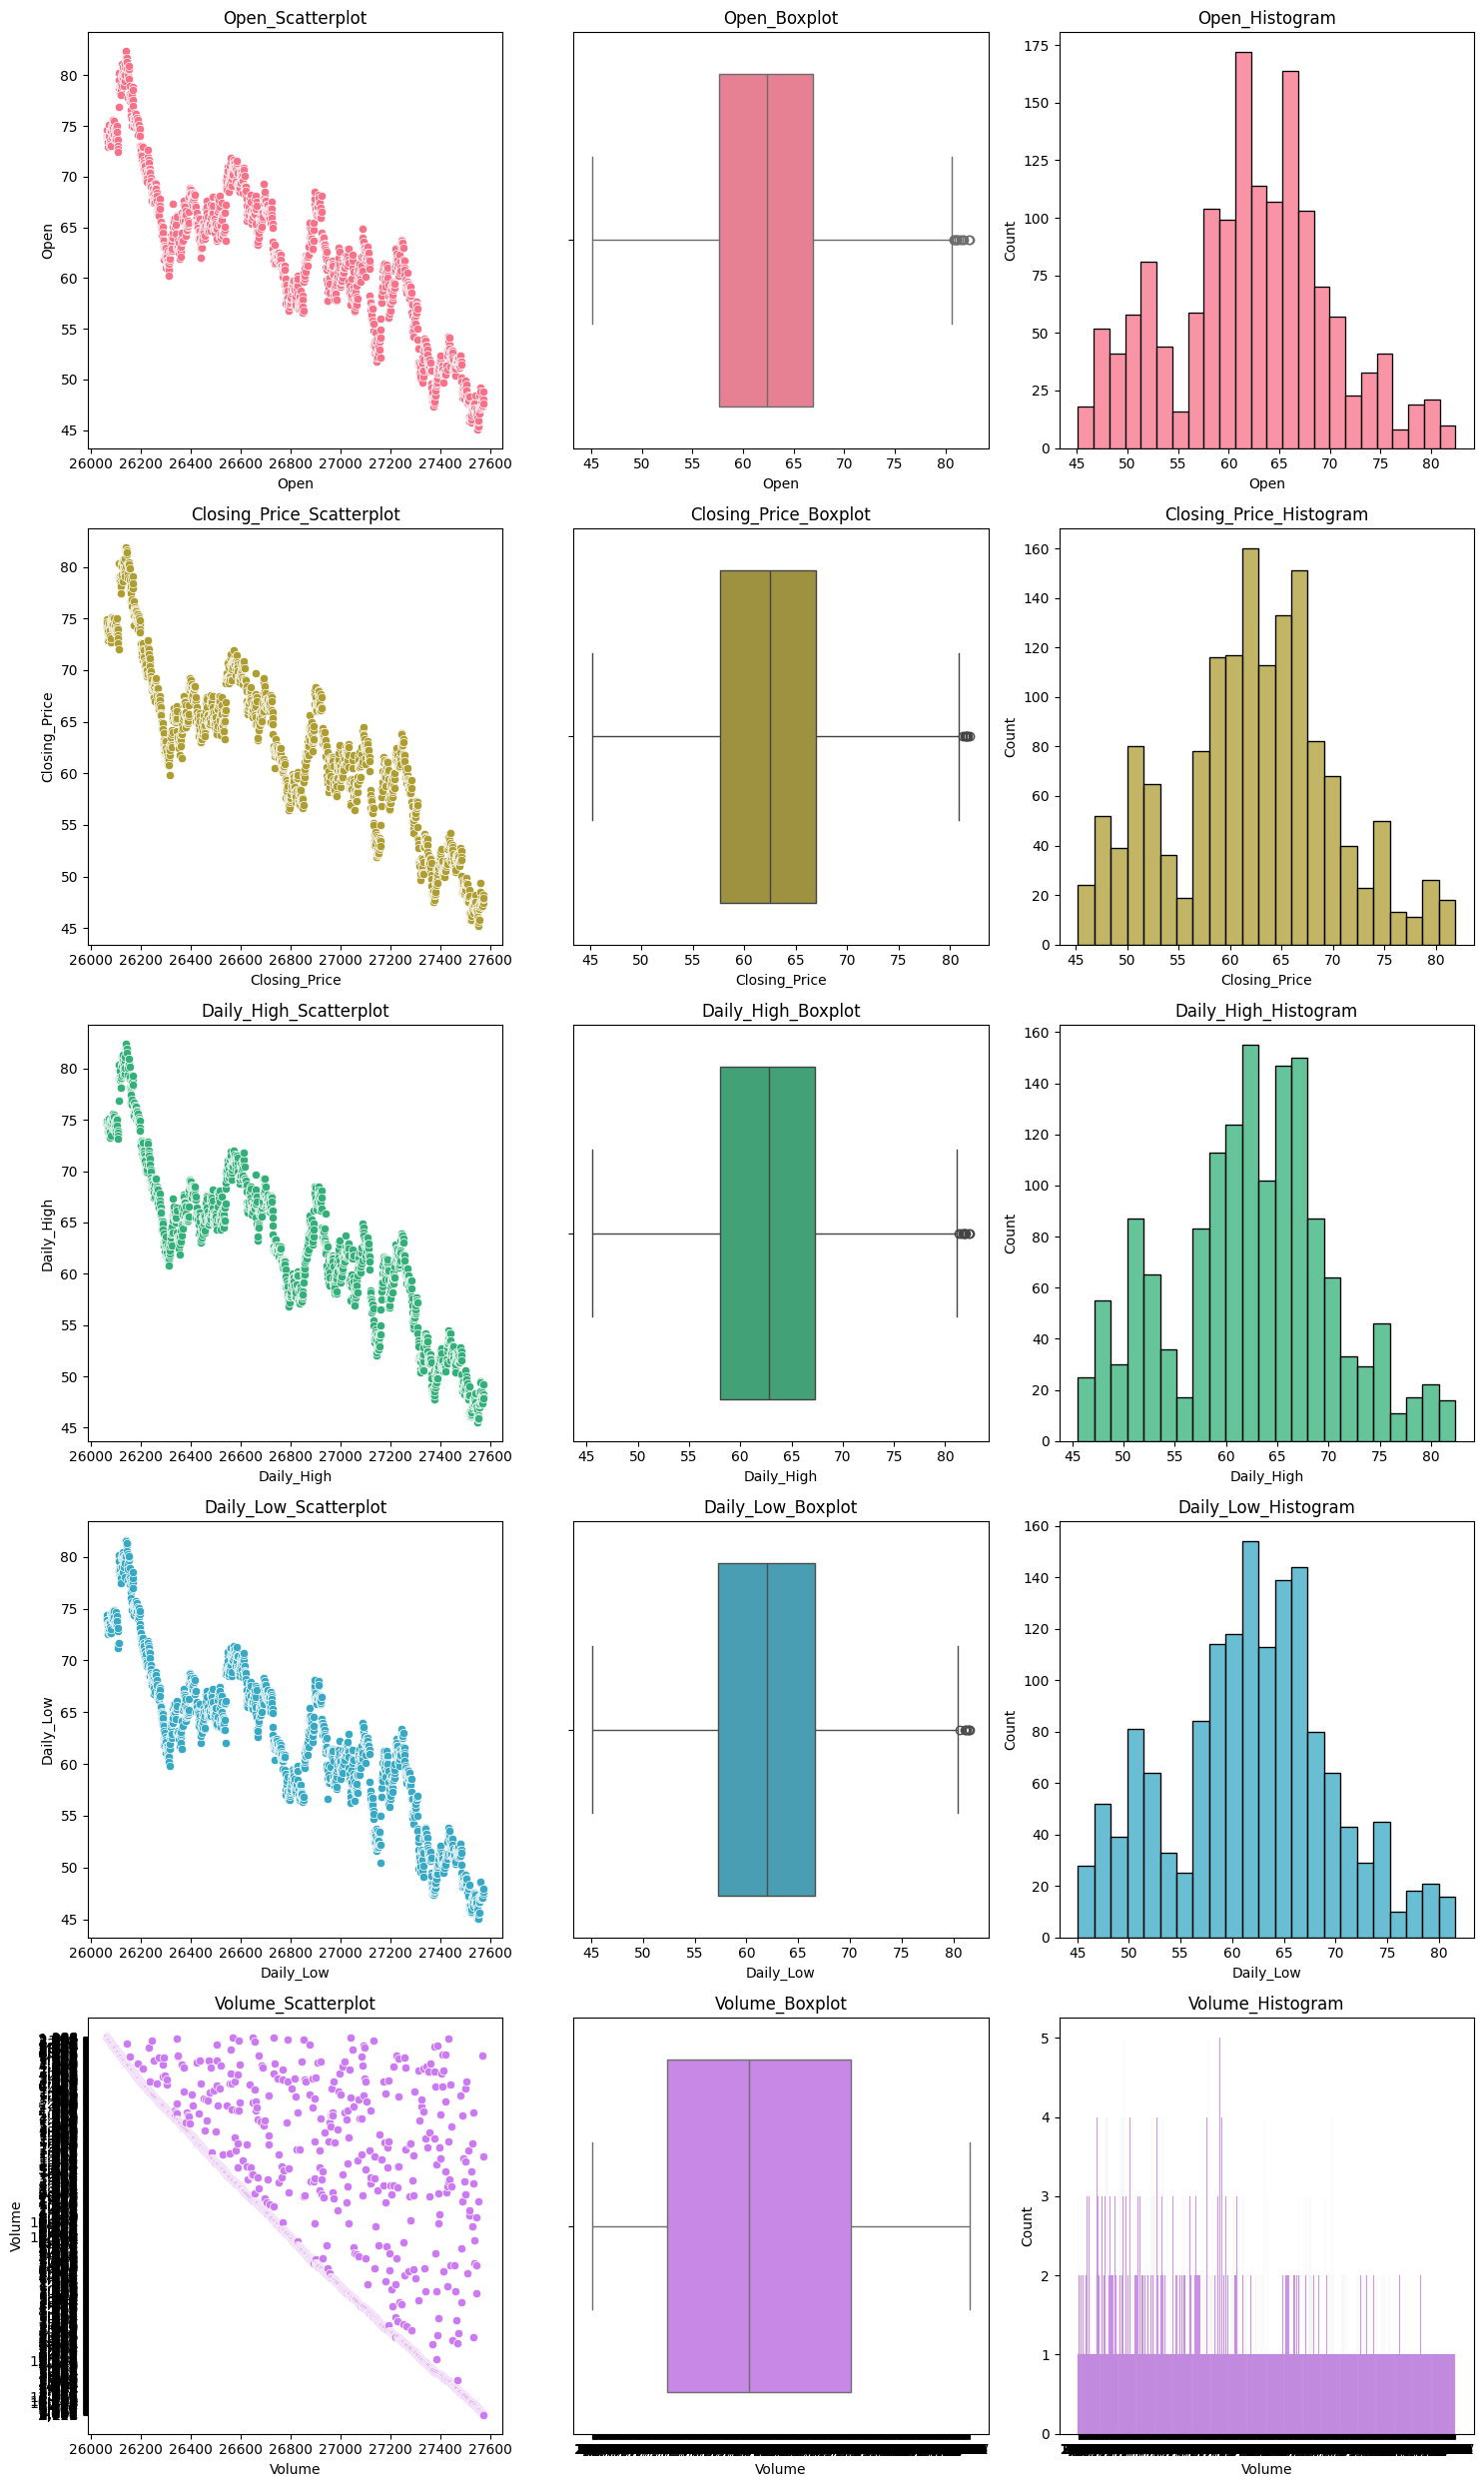

In [17]:
import seaborn as sns
from typing import List
def numeric_plots(df:pd.DataFrame, col_names:List["str"], save_path=None):
    colors = sns.color_palette("husl", len(col_names))
    fig, axes = plt.subplots(len(col_names), 3, figsize=(15, len(col_names)*5))
    for i, col_name in enumerate(col_names):
        sns.scatterplot(df[col_name], ax=axes[i, 0], color=colors[i])
        axes[i, 0].set_title(f'{col_name}_Scatterplot')
        axes[i, 0].set_xlabel(col_name)

        sns.boxplot(df[col_name], ax=axes[i, 1], orient='h', color=colors[i])
        axes[i, 1].set_title(f'{col_name  }_Boxplot')
        axes[i, 1].set_xlabel(col_name)

        sns.histplot(df[col_name], ax=axes[i, 2], color=colors[i])
        axes[i, 2].set_title(f'{col_name}_Histogram')
        axes[i, 2].set_xlabel(col_name)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

numeric_plots(specific_df, ["Open", "Closing_Price", "Daily_High", "Daily_Low", "Volume"])

## Visualization

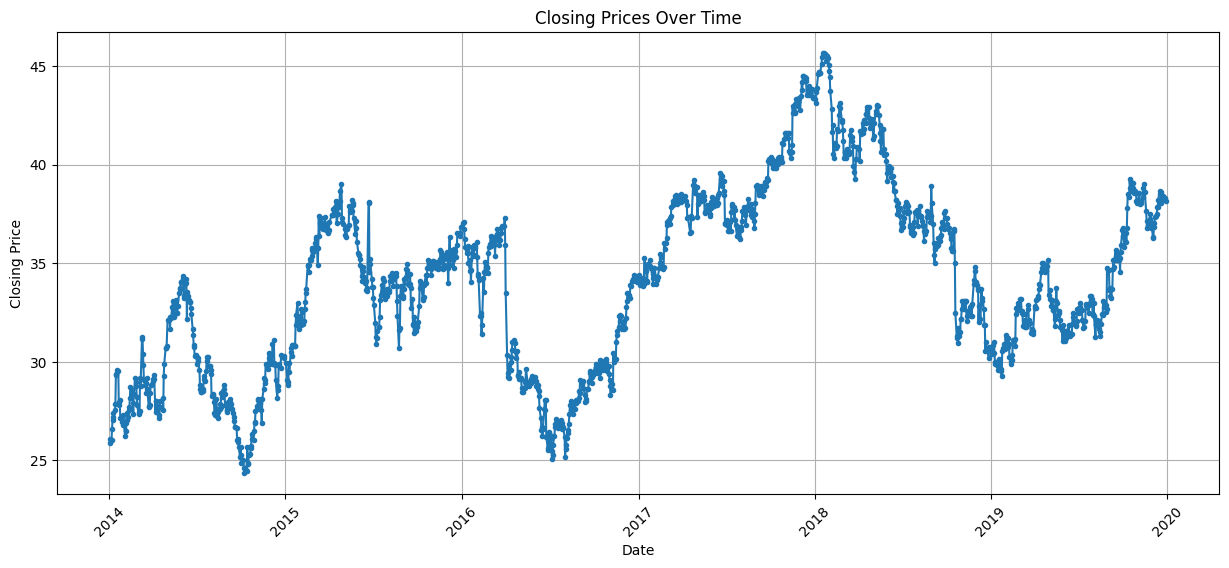

In [7]:
# Line Chart of Closing Prices Over Time

# Convert 'Date' column to datetime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

NameError: name 'candlestick_ohlc' is not defined

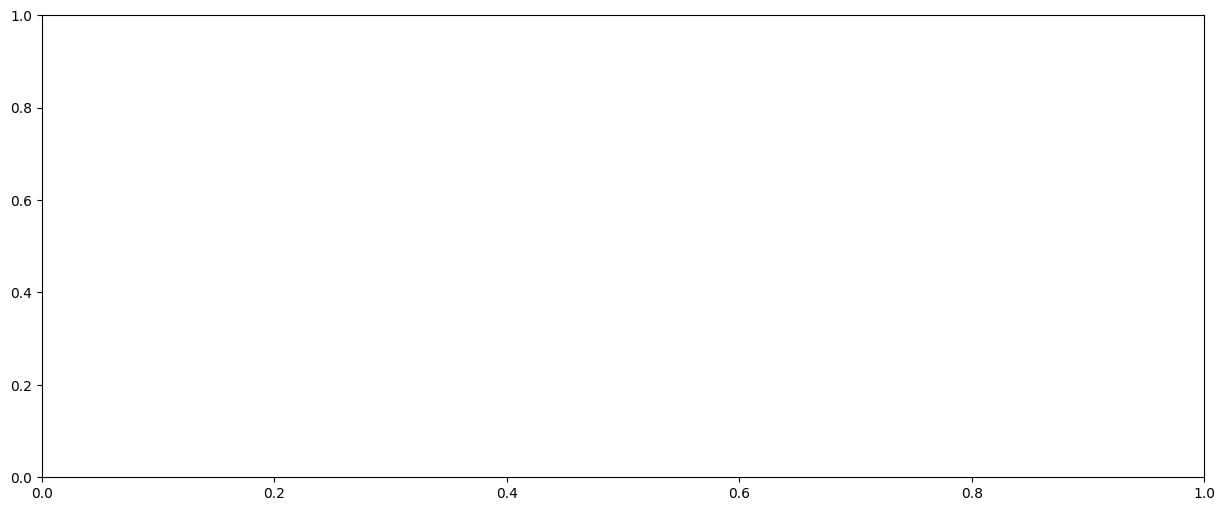

In [8]:
# Candlestick Chart

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['Daily_High'], specific_df['Daily_Low'], specific_df['Closing_Price'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

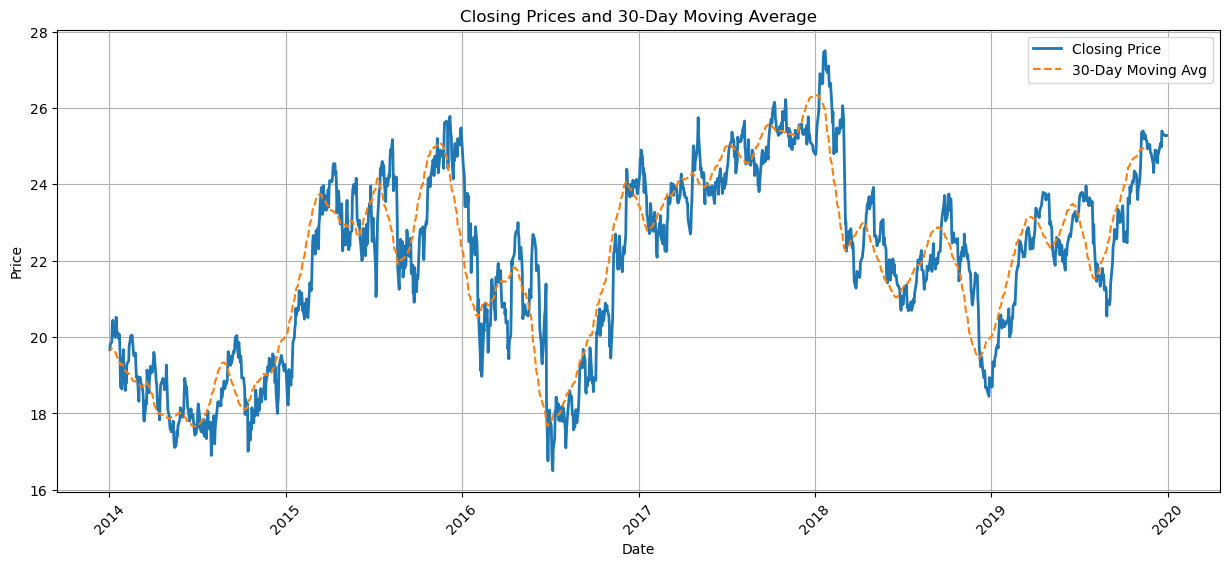

In [ ]:
# Closing Prices and Moving Average plot

window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Closing_Price'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Closing_Price'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

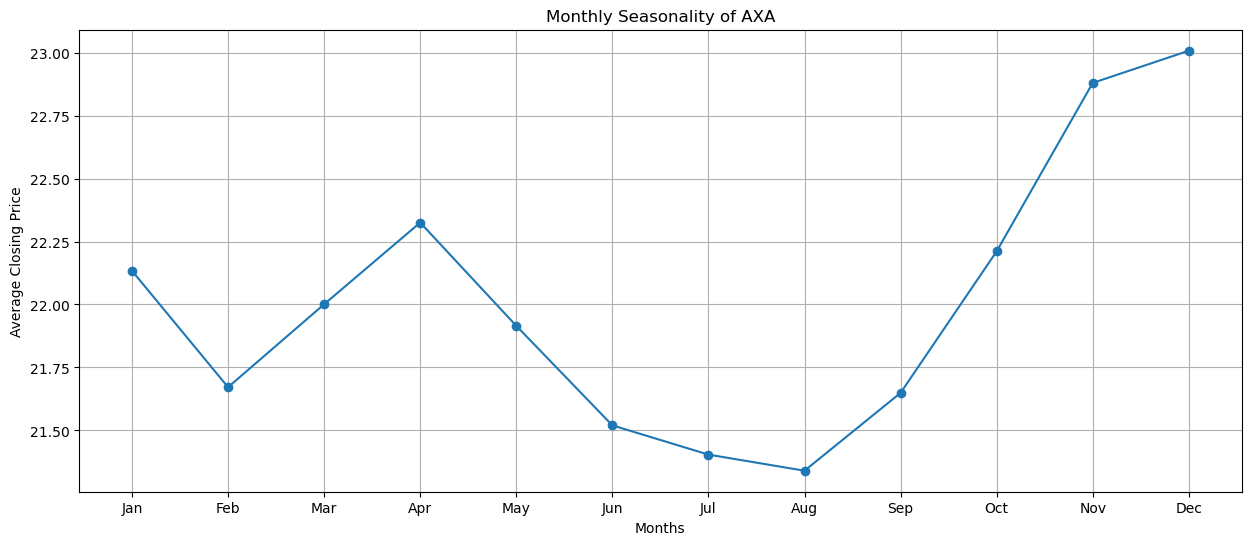

In [ ]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Closing_Price'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [ ]:
specific_df.head()

,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume,Month
13067,AXA,2019-12-30,25.31,25.28,25.31,25.24,"4,199",12
13068,AXA,2019-12-27,25.45,25.27,25.45,25.27,"1,15",12
13069,AXA,2019-12-23,25.41,25.31,25.41,25.29,"6,698",12
13070,AXA,2019-12-20,25.04,25.40,25.40,25.03,"9,469",12
13071,AXA,2019-12-19,25.10,24.98,25.10,24.98,"7,995",12


In [ ]:
new_df = specific_df.reset_index()['Closing_Price']

In [ ]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [ ]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [ ]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1151, 60)
(1151,)


Testing set size:-
(243, 60)
(243,)


(None, None)

In [ ]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model training


In [ ]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
36/36 [==============================] - 12s 142ms/step - loss: 0.0625 - val_loss: 0.0119
Epoch 2/100
36/36 [==============================] - 4s 101ms/step - loss: 0.0132 - val_loss: 0.0086
Epoch 3/100
36/36 [==============================] - 4s 98ms/step - loss: 0.0100 - val_loss: 0.0047
Epoch 4/100
36/36 [==============================] - 4s 98ms/step - loss: 0.0096 - val_loss: 0.0046
Epoch 5/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0092 - val_loss: 0.0044
Epoch 6/100
36/36 [==============================] - 3s 94ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 7/100
36/36 [==============================] - 3s 97ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 8/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 9/100
36/36 [==============================] - 3s 96ms/step - loss: 0.0079 - val_loss: 0.0038
Epoch 10/100
36/36 [==============================] - 4s 102ms/step - loss: 0.0075 - val_loss: 0.

In [ ]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 29ms/step


In [ ]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

22.134469691491343
18.501902226637945


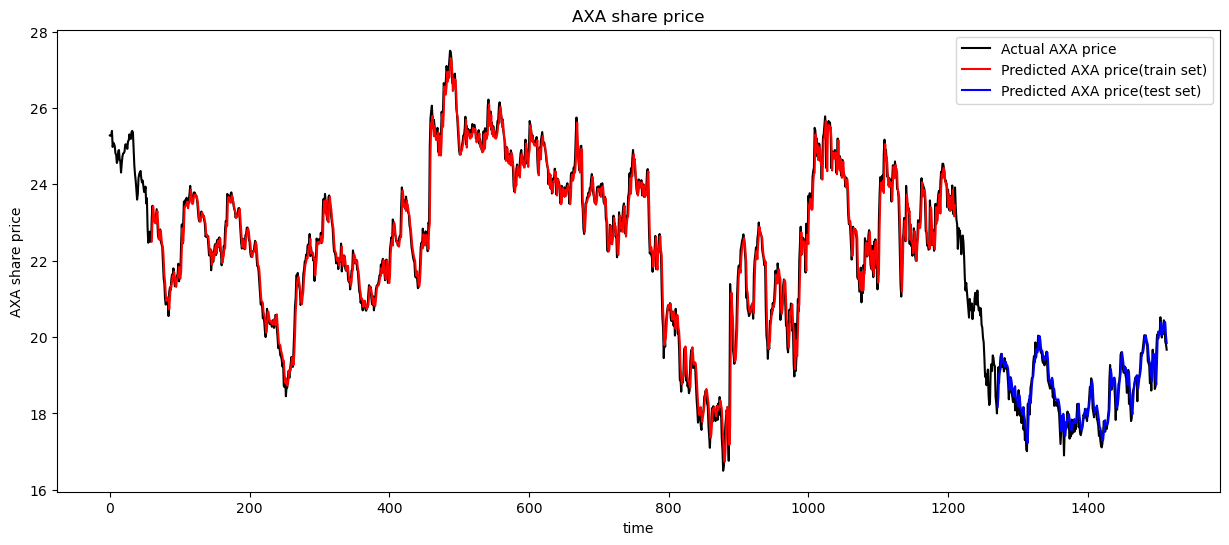

In [ ]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()

In [ ]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 33ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 19.84246253967285
Day 2: Predicted Price = 19.848648071289062
Day 3: Predicted Price = 19.893957138061523
Day 4: Predicted Price = 19.93724822998047
Day 5: Predicted Price = 19.97552490234375
Day 6: Predicted Price = 20.009977340698242
Day 7: Predicted Price = 20.041526794433594
Day 8: Predicted Price = 20.070781707763672
Day 9: Predicted Price = 20.098102569580078
Day 10: Predicted Price = 20.123676300048828


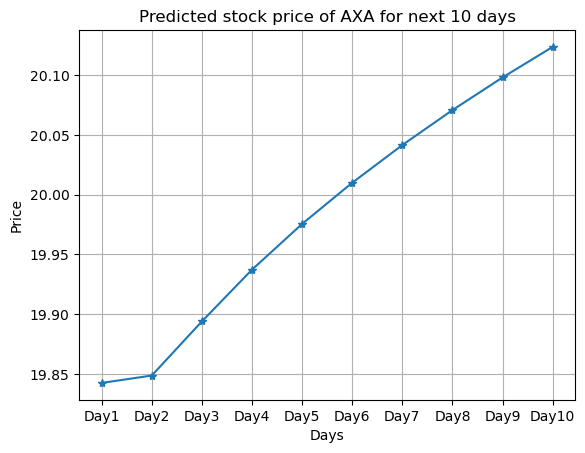

In [ ]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()